# Example: Option Pricing

Miranda and Fackler, Applied Computational Economics and Finance, 2002, Section 7.6.4

In [1]:
%matplotlib inline

In [2]:
from __future__ import division
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import quantecon as qe
from quantecon.markov import DiscreteDP

In [3]:
T = 0.5       # Time expiration (years)
vol = 0.2     # Annual volatility
r = 0.05      # Annual interest rate
strike = 2.1  # Strike price
p0 = 2        # Current price
N = 100       # Number of periods to expiration

# Time length of a period
tau = T/N

# Discount factor
beta = np.exp(-r*tau)

# Up-jump factor
u = np.exp(vol*np.sqrt(tau))

# Up-jump probability
q = 1/2 + np.sqrt(tau)*(r - vol**2/2)/(2*vol)

We follow the state-action pairs formulation approach.
We let the state space consist of the possible values of the asset price
and the state indicating that "the option has been exercised".

In [4]:
# Possible price values
ps = u**np.arange(-N, N+1) * p0

# Number of states
n = len(ps) + 1  # State n-1: "the option has been exercised"

# Number of actions
m = 2  # 0: hold, 1: exercise

# Number of feasible state-action pairs
L = n*m - 1  # At state n-1, there is only one action "do nothing"

In [5]:
s_indices, a_indices = qe.markov.random._sa_indices(n, m)
s_indices, a_indices = s_indices[:-1], a_indices[:-1]

In [6]:
R = np.zeros((n, m))
R[:-1, 1] = strike - ps
R = R.ravel()[:-1]

In [7]:
Q = sp.lil_matrix((L, n))
for i in range(L-1):
    if a_indices[i] == 0:
        Q[i, min(s_indices[i]+1, len(ps)-1)] = q
        Q[i, max(s_indices[i]-1, 0)] = 1 - q
    else:
        Q[i, n-1] = 1
Q[L-1, n-1] = 1

In [8]:
ddp = DiscreteDP(R, Q, beta, s_indices, a_indices)

While `DiscreteDP` does not have a finite-horizon backward induction algorithm,
it is easy to implement by using its `bellman_operator` method in a for loop.

In [9]:
v = np.zeros(ddp.num_states)
sigma = np.empty(ddp.num_states, dtype=int)
max_exercise_price = np.empty(N)
for i in range(N):
    v = ddp.bellman_operator(v, sigma=sigma)
    max_exercise_price[i] = ps[sigma.sum()-1]

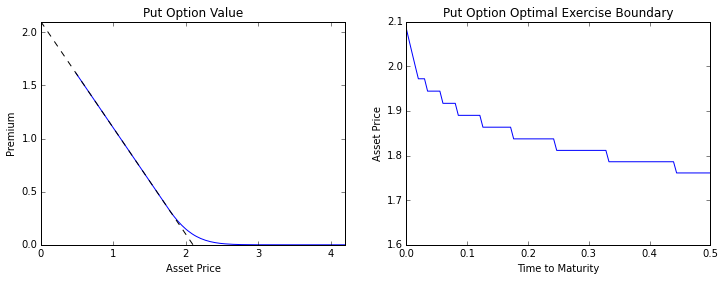

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(ps, v[:-1])
axes[0].plot([0, strike], [strike, 0], 'k--')
axes[0].set_xlim(0, strike*2)
axes[0].set_xticks(np.linspace(0, 4, 5, endpoint=True))
axes[0].set_ylim(0, strike)
axes[0].set_xlabel('Asset Price')
axes[0].set_ylabel('Premium')
axes[0].set_title('Put Option Value')

axes[1].plot(np.linspace(0, T, N), max_exercise_price)
axes[1].set_ylim(1.6, strike)
axes[1].set_xlabel('Time to Maturity')
axes[1].set_ylabel('Asset Price')
axes[1].set_title('Put Option Optimal Exercise Boundary')

plt.show()

The figure in the right panel looks different from
the corresponding figure in Miranda and Fackler (Figure 7.4(b), p.180).